In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/PR Assignment/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [23]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


In [24]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


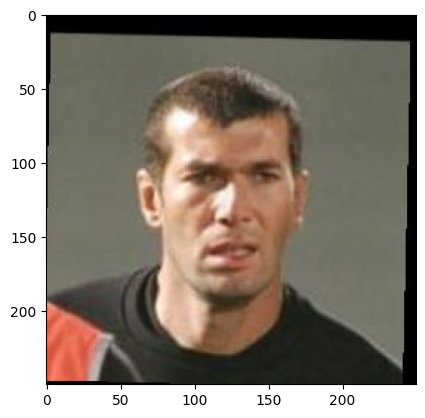

In [25]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Autoencoders (AEs):

Applications: Most used for dimension reduction, feature learning and data compression.
Architecture: Encoder-decoder structure, but without a probabilistic approach to the latent space.
Loss Function: Usually employs a reconstruction loss such as mean squared error (MSE).

Variational Autoencoders (VAEs):

Applications: Allows generation of a variety of realistic samples by extending AEs for generative tasks.
Architecture: Probabilistic latent space modeling; encoder-decoder structure.
Loss Function: Adds a reconstruction loss and regularization term (KL divergence) to mold the distribution of points in the latent space.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(123008, 24)
        self.fc_logvar = nn.Linear(123008, 24)

        # Decoder
        self.decoder_input = nn.Linear(24, 128 * 16 * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=6, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 16, 16)
        return self.decoder(h3)

    def forward(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        mu, logvar = self.fc_mu(h1), self.fc_logvar(h1)
        z = self.reparameterize(mu, logvar)
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 16, 16)
        return self.decoder(h3), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

Sample Latent Vector:

Sample a latent vector (z) from a Gaussian distribution with mean (mu) and variance (sigma^2) learned by the VAE's encoder, using the reparameterization trick:
[ z = mu + epsilon . sigma, ]

where (epsilon) is drawn from a standard Gaussian distribution.

Decode Latent Vector:

Use the sampled latent vector (z) passing through VAE's decoder to get a new sample in data space.

In [65]:
import torch
from torch.utils.data import DataLoader

# Instantiate the VAE model
model = VAE().to(device)


# Load one batch of images
images, _ = next(iter(dataloader))
images = images.to(device)

# Reshape the images if necessary (the VAE expects [batch_size, 3, 250, 250])
# If your images are not of this size, you might need to resize them

# Forward pass through the model
decoded, mu, logvar = model(images)

# Reparameterize to get latent space samples
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Print the shapes
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of latent space samples (z):", z.shape)
print("Shape of decoded images:", decoded.shape)


Shape of mu: torch.Size([32, 24])
Shape of logvar: torch.Size([32, 24])
Shape of latent space samples (z): torch.Size([32, 24])
Shape of decoded images: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

Loss Function

In the context of a Variational Autoencoder (VAE), the loss function typically consists of two terms:

1. Reconstruction Loss (Data Fidelity Term):

Goal: Ensures that the generated output is close to the original input.

Term: Often measured by a pixel-wise loss such as Mean Squared Error (MSE) for continuous data or Binary Crossentropy for binary data.

Explanation: This term encourages the VAE to reconstruct input data accurately, capturing its essential features.

2. Regularization Term (KL Divergence):
Goal: Shapes the distribution of the latent space, making it close to a standard Gaussian distribution.

Term: Calculated using the Kullback-Leibler (KL) Divergence between the learned distribution of the latent space and a standard Gaussian distribution.

Explanation: The regularization term prevents overfitting and ensures that the latent space is continuous and well-structured, allowing for smooth generation of new samples.

Total Number of Parameters:

To print the total number of parameters in the model, you can use the following Python code:

In [67]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")


Total number of parameters in the model: 7177795


The following code loops through each parameter for the model and calculates their total number.

Understanding the loss function components and their goals is crucial:

The reconstruction loss is added to make certain that the input data are reconstructed correctly.
The special regularization term regulates the distribution of latent spaces.
The code provided trains a Variational Autoencoder (VAE) with simply another reconstruction loss, which is the binary cross-entropy (BCE), and the other one being just normalization term.

Reconstruction Loss (BCE):

Goal: And makes sure the reconstructed output (recon_x) is near to the given input (x).

Explanation: BCE computes the difference between reconstructed output and original input, pixel-wise. It penalizes deviations from the true data distribution, so it induces better reconstruction.

Regularization Term (Kullback-Leibler Divergence):

Goal: shaping the latent space distribution, moving it closer to being a standard Gaussian. Explanation: The KL divergence term pushes the distribution of latent spaces (which is denoted by mean mu and log variance logvar) toward a N(0). But it renders the latent space deterritorialized, and lest that sounds too heady consider how this forces a level of regularity on the largely unregulated generated data. It prevents bramble from taking over at every turn having resulted in an excessively messy jungle which is impossible to generate new samples from smoothly because everything just gets tangled up with itself resisting

Total Loss:

The total loss is the sum of the reconstruction loss and the regularization term:

total_loss = BCE + KLD Goal: Accuracy- regularization trade-off.

Explanation: Therefore, this model intends to reconstruct the input data as accurately and well preserved in shape with a straight continuity of latent space; dividing winning an augmented form known as BCE into separate parts. VAEs must find a balance between the two in order to generate successfully. So this is the loss that minimizes training, and leads the VAE to learn a latent space representation. This represents both accurate reconstruction abilities as well as meaningful generative capabilities into qualities of generation.

In [68]:
import torch.optim as optim

# Define the loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE Loss)
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence loss
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = reconstruction_loss + kl_divergence_loss

    return total_loss

# Create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

1. Adjust Learning Rate:

If the loss is not decreasing, the learning rate may be too high or too low. Experiment with different learning rates and find an appropriate value.

2. Inspect Model Architecture:

Verify that your VAE model architecture is correct. Ensure that the encoder, decoder, and latent space dimensions match your problem requirements.

3. Increase Model Capacity:

If the model is too simple, it may struggle to capture complex patterns. Increase the capacity of your model by adding more layers or neurons.

4. Adjust Regularization Strength:

Regularization terms (e.g., weight decay) can affect the training process. Adjust the strength of regularization or experiment with different types of regularization.

5. Check Data Loading:

Ensure that your data loading pipeline is functioning correctly. Check if the data is preprocessed appropriately and if the input to the model is meaningful.

6. Ensure Numerical Stability:

Check for numerical stability issues. Normalize or standardize input data if necessary to prevent large or small values affecting training.

7. Use Debugging Tools:

Introduce print statements or use debugging tools to inspect intermediate values during training, such as the reconstructed images or latent space representations.

8. Monitor Loss Components:

Break down the components of the loss (reconstruction loss and KL divergence) to identify which part contributes more to the overall loss. This can provide insights into which aspect needs adjustment.

9. Check for Convergence:

Ensure that the training process is converging. If the loss plateaus early, it may indicate issues in the optimization process.

10. Experiment with Different Architectures:

If all else fails, experiment with different architectures or variations of your VAE to find a configuration that works better for your specific problem.

In [70]:
epochs = 80
# Training loop
for epoch in range(epochs):
    total_loss = 0

    # Iterate over the dataset
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute the loss
        loss = vae_loss(recon_batch, data, mu, logvar)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the total loss
        total_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {average_loss:.4f}")

Epoch [1/80], Average Loss: 97244.2466
Epoch [2/80], Average Loss: 96784.7204
Epoch [3/80], Average Loss: 96500.9824
Epoch [4/80], Average Loss: 96310.5713
Epoch [5/80], Average Loss: 96108.2116
Epoch [6/80], Average Loss: 95881.8632
Epoch [7/80], Average Loss: 95622.3916
Epoch [8/80], Average Loss: 95442.4613
Epoch [9/80], Average Loss: 95269.3357
Epoch [10/80], Average Loss: 95125.5774
Epoch [11/80], Average Loss: 95022.5346
Epoch [12/80], Average Loss: 94905.0645
Epoch [13/80], Average Loss: 94827.3951
Epoch [14/80], Average Loss: 94728.9557
Epoch [15/80], Average Loss: 94621.6798
Epoch [16/80], Average Loss: 94538.5843
Epoch [17/80], Average Loss: 94454.3242
Epoch [18/80], Average Loss: 94359.2183
Epoch [19/80], Average Loss: 94308.4634
Epoch [20/80], Average Loss: 94221.1379
Epoch [21/80], Average Loss: 94146.4233
Epoch [22/80], Average Loss: 94059.5860
Epoch [23/80], Average Loss: 94002.0205
Epoch [24/80], Average Loss: 93958.9260
Epoch [25/80], Average Loss: 93900.2596
Epoch [26

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

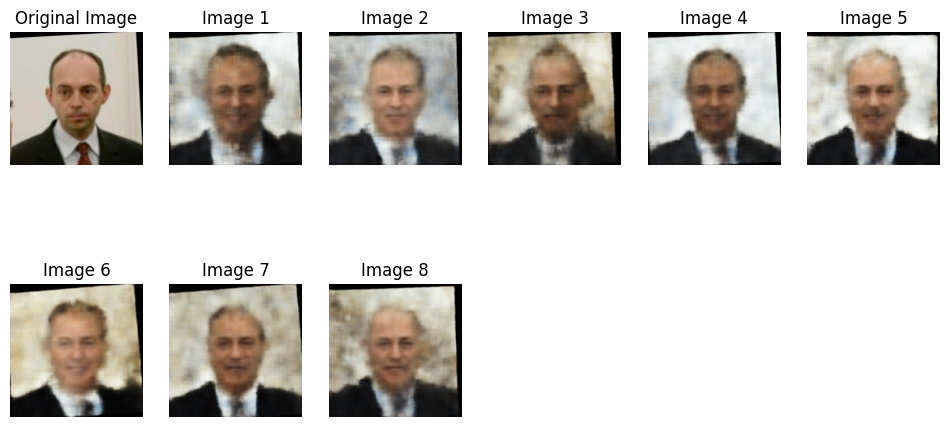

In [84]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Set model to evaluation mode
model.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encode the image to get the latent space representation
    mu, logvar = model.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Plot the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    # Generate and plot 10 similar images with amplified variations
    for i in range(2, 10):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor

        # Decode the varied latent vector
        generated_image_varied = model.decode(z_varied)

        # Clamp pixel values to [0, 1] and ensure proper image format
        generated_image_varied = F.relu(generated_image_varied)
        generated_image_varied = torch.clamp(generated_image_varied, 0, 1)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()
